In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/
# !unzip 'CS552J_DMDL_Assessment_1_Dataset.zip'

/content/drive/MyDrive


# The task: Detect Covid-19 from Chest X-Ray Images using neural networks – (max ~ 1600words)

<br>

Subtask 1: Develop deep learning models to classify Covid-19 and Normal CXRs. 
- Convolutional neural networks (CNNs) will be used in this task. 
- For comparison purposes, purely feed forward neural networks (FNN) will also be applied to this problem. Compare the performance between CNN and FNN. Explain why CNNs would be more suitable for image classification (5 Marks). 
- You must explore generalization techniques, such as data augmentation, weight decay, early stopping,ensembles, and dropout. 
- You must demonstrate how each of these techniques was used, and justifywhich (maybe more than one of these techniques) would be the best generalization techniques for this task (10 Marks). 
- Report the performance in terms of accuracy of your models.
- You must explain the network architecture used in your model, explain how you have monitored the convergence of the model, and how overfitting was prevented (10 Marks). 

To accomplish this, use the 100 Covid-19 and 100 Normal CXRs images provided to you. Follow 80% (train) / 20% (test) process.

<hr><br>

We must create two distinct models utilizing these architectures in order to compare the performance of CNN and FNN for categorizing Covid-19 and Normal CXRs.

Let's talk about why CNNs are more suited for image classification jobs than FNNs before continuing.


By applying filters to various areas of the image, CNNs are made to recognize features and patterns in images. The CNN can recognize regional patterns in the image, such as edges, corners, and textures, thanks to these filters, which it learns during the training phase.

FNNs, on the other hand, are made to function with data that has a grid-like structure, like tabular data or time series data. FNNs are not as good at spotting patterns in images since they don't include spatial relationships between pixels.

Therefore, CNNs are more suitable for image classification tasks because they can learn and detect complex features in images that are crucial for accurate classification.

<br>

1. Preprocessing the data : We need to preprocess the dataset to prepare it for training the CNN. This step involves resizing the images to a standard size, normalizing the pixel values, and splitting the dataset into training, validation, and testing sets.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import regularizers
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization

## Data Processing

In [4]:
#The path of our data on drive
data_dir =  'CS552J_DMDL_Assessment_1_Dataset'
 
#Loading Data
data = load_files(data_dir)

In [5]:
folders=os.listdir("CS552J_DMDL_Assessment_1_Dataset")
print(folders)

['Normal', 'Covid-19']


In [6]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  CS552J_DMDL_Assessment_1_Dataset/Covid-19/16654_2_1.jpg
Target labels -  0
Number of training files :  200
Number of training targets :  200


In [7]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(200, 224, 224, 3)
First training item :  [[[ 83.  83.  83.]
  [ 56.  56.  56.]
  [ 32.  32.  32.]
  ...
  [ 73.  73.  73.]
  [180. 180. 180.]
  [237. 237. 237.]]

 [[ 86.  86.  86.]
  [ 51.  51.  51.]
  [ 31.  31.  31.]
  ...
  [ 72.  72.  72.]
  [173. 173. 173.]
  [234. 234. 234.]]

 [[ 85.  85.  85.]
  [ 51.  51.  51.]
  [ 31.  31.  31.]
  ...
  [ 70.  70.  70.]
  [171. 171. 171.]
  [233. 233. 233.]]

 ...

 [[122. 122. 122.]
  [128. 128. 128.]
  [133. 133. 133.]
  ...
  [134. 134. 134.]
  [165. 165. 165.]
  [185. 185. 185.]]

 [[120. 120. 120.]
  [128. 128. 128.]
  [138. 138. 138.]
  ...
  [138. 138. 138.]
  [159. 159. 159.]
  [186. 186. 186.]]

 [[120. 120. 120.]
  [124. 124. 124.]
  [131. 131. 131.]
  ...
  [131. 131. 131.]
  [141. 141. 141.]
  [182. 182. 182.]]]


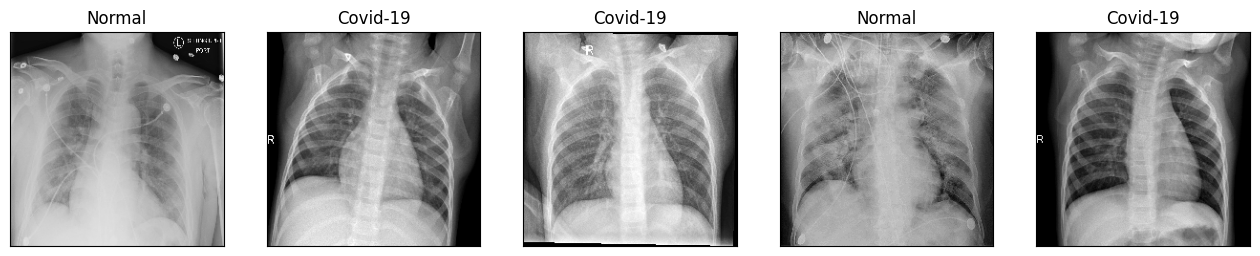

In [8]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [9]:

"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [10]:
y

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1])

In [11]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(to_categorical(y,no_of_classes))
y[0]

array([1., 0.], dtype=float32)

In [12]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  160
The validation Data Shape  20
The test Data Shape  20


In [13]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


2. Implementing 5 different models:
- model_cnn = CNN model with 50 epochs
- model_cnn1 = CNN model with regularization
- model_cnn2 = CNN model with learning rate and 100 epochs
- model_cnn3 = CNN model with early stopping
- model_cnn4 = CNN model with weight decay and data augmentation

In [14]:
# CNN model0

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
5/5 [==============================] - 26s 5s/step - loss: 0.7808 - accuracy: 0.5562 - val_loss: 0.6542 - val_accuracy: 0.9500
Epoch 2/50
5/5 [==============================] - 22s 4s/step - loss: 0.6220 - accuracy: 0.7375 - val_loss: 0.4859 - val_accuracy: 0.8500
Epoch 3/50
5/5 [==============================] - 24s 5s/step - loss: 0.3515 - accuracy: 0.9375 - val_loss: 0.0617 - val_accuracy: 1.0000
Epoch 4/50
5/5 [==============================] - 23s 5s/step - loss: 0.2104 - accuracy: 0.9312 - val_loss: 0.0437 - val_accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 25s 5s/step - loss: 0.1510 - accuracy: 0.9563 - val_loss: 0.1254 - val_accuracy: 0.9500
Epoch 6/50
5/5 [==============================] - 22s 5s/step - loss: 0.1109 - accuracy: 0.9750 - val_loss: 0.1908 - val_accuracy: 0.9500
Epoch 7/50
5/5 [==============================] - 24s 4s/step - loss: 0.0839 - accuracy: 0.9812 - val_loss: 0.1959 - val_accuracy: 0.9500
Epoch 8/50
5/5 [==================

In [15]:
# evaluate CNN model0
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

1/1 [==============================] - 1s 661ms/step - loss: 0.4791 - accuracy: 0.9000
Test accuracy: 0.8999999761581421
Test loss: 0.479095458984375


In [16]:

# CNN model with regularization

model_cnn1 = Sequential()
model_cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Flatten())
model_cnn1.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(Dense(2, activation='softmax'))

model_cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn1 = model_cnn1.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
5/5 [==============================] - 27s 5s/step - loss: 1.7335 - accuracy: 0.5875 - val_loss: 1.4119 - val_accuracy: 0.8500
Epoch 2/50
5/5 [==============================] - 22s 5s/step - loss: 1.2107 - accuracy: 0.8000 - val_loss: 0.8063 - val_accuracy: 1.0000
Epoch 3/50
5/5 [==============================] - 25s 5s/step - loss: 0.7846 - accuracy: 0.8875 - val_loss: 0.5253 - val_accuracy: 0.9500
Epoch 4/50
5/5 [==============================] - 23s 5s/step - loss: 0.5779 - accuracy: 0.9312 - val_loss: 0.4378 - val_accuracy: 0.9500
Epoch 5/50
5/5 [==============================] - 23s 5s/step - loss: 0.4675 - accuracy: 0.9625 - val_loss: 0.4394 - val_accuracy: 0.9500
Epoch 6/50
5/5 [==============================] - 23s 5s/step - loss: 0.4222 - accuracy: 0.9625 - val_loss: 0.4458 - val_accuracy: 0.9500
Epoch 7/50
5/5 [==============================] - 24s 5s/step - loss: 0.4034 - accuracy: 0.9563 - val_loss: 0.6054 - val_accuracy: 0.9000
Epoch 8/50
5/5 [==================

In [17]:
# evaluate CNN model1
test_loss_cnn, test_acc_cnn = model_cnn1.evaluate(X_test, y_test)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

1/1 [==============================] - 1s 717ms/step - loss: 0.4625 - accuracy: 0.9000
Test accuracy: 0.8999999761581421
Test loss: 0.46251946687698364


In [18]:

# CNN model with Learning Rate = 0.0001 and epochs = 100

model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.0001)

model_cnn2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history_cnn2 = model_cnn2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 [==============================] - 26s 5s/step - loss: 2.0169 - accuracy: 0.5562 - val_loss: 1.5192 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 25s 5s/step - loss: 1.4191 - accuracy: 0.5562 - val_loss: 1.2634 - val_accuracy: 0.5500
Epoch 3/100
5/5 [==============================] - 22s 5s/step - loss: 1.1837 - accuracy: 0.7125 - val_loss: 1.0234 - val_accuracy: 0.9500
Epoch 4/100
5/5 [==============================] - 25s 5s/step - loss: 0.8990 - accuracy: 0.8938 - val_loss: 0.6577 - val_accuracy: 0.9500
Epoch 5/100
5/5 [==============================] - 23s 5s/step - loss: 0.6682 - accuracy: 0.9125 - val_loss: 0.5633 - val_accuracy: 0.9500
Epoch 6/100
5/5 [==============================] - 24s 5s/step - loss: 0.7817 - accuracy: 0.8750 - val_loss: 0.5570 - val_accuracy: 0.9500
Epoch 7/100
5/5 [==============================] - 22s 5s/step - loss: 0.6326 - accuracy: 0.9250 - val_loss: 0.5697 - val_accuracy: 0.9500
Epoch 8/100
5/5 [==========

In [19]:
# evaluate CNN model2
test_loss_cnn, test_acc_cnn = model_cnn2.evaluate(X_test, y_test)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

1/1 [==============================] - 1s 796ms/step - loss: 0.1627 - accuracy: 0.9500
Test accuracy: 0.949999988079071
Test loss: 0.16265340149402618


In [20]:
# CNN model with lr and early stopping

model_cnn3 = Sequential()
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Flatten())
model_cnn3.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.0001)

model_cnn3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history_cnn3 = model_cnn3.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid), callbacks=[es])

Epoch 1/100
5/5 [==============================] - 25s 5s/step - loss: 1.8192 - accuracy: 0.5063 - val_loss: 1.5843 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 24s 5s/step - loss: 1.4059 - accuracy: 0.5938 - val_loss: 1.2256 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 22s 5s/step - loss: 1.0672 - accuracy: 0.8062 - val_loss: 0.8021 - val_accuracy: 0.9500
Epoch 4/100
5/5 [==============================] - 25s 5s/step - loss: 0.7846 - accuracy: 0.9000 - val_loss: 0.6657 - val_accuracy: 0.9500
Epoch 5/100
5/5 [==============================] - 23s 5s/step - loss: 0.6661 - accuracy: 0.9062 - val_loss: 0.6483 - val_accuracy: 0.9500
Epoch 6/100
5/5 [==============================] - 24s 5s/step - loss: 0.6032 - accuracy: 0.8938 - val_loss: 0.4462 - val_accuracy: 0.9500
Epoch 7/100
5/5 [==============================] - 22s 5s/step - loss: 0.5275 - accuracy: 0.9312 - val_loss: 0.4669 - val_accuracy: 0.9500
Epoch 8/100
5/5 [==========

In [21]:
# evaluate CNN model3
test_loss_cnn, test_acc_cnn = model_cnn3.evaluate(X_test, y_test)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

1/1 [==============================] - 1s 645ms/step - loss: 0.2748 - accuracy: 0.9500
Test accuracy: 0.949999988079071
Test loss: 0.2748171091079712


In [22]:
bs = 32
epochs = 100

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")

train_generator = train_datagen.flow(X_train, y_train, batch_size=bs)

model_cnn4 = Sequential()
model_cnn4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Flatten())
model_cnn4.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(Dropout(0.5))
model_cnn4.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.0001)

model_cnn4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

history_cnn4 = model_cnn4.fit(train_generator, steps_per_epoch=len(X_train)//bs, epochs=100, validation_data=(X_valid, y_valid), validation_steps=len(X_valid)//bs, callbacks=[es])

Epoch 1/100
5/5 [==============================] - 25s 5s/step - loss: 1.7968 - accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 24s 5s/step - loss: 1.3627 - accuracy: 0.5562
Epoch 3/100
5/5 [==============================] - 30s 6s/step - loss: 1.1153 - accuracy: 0.6938
Epoch 4/100
5/5 [==============================] - 25s 5s/step - loss: 0.8971 - accuracy: 0.7875
Epoch 5/100
5/5 [==============================] - 25s 5s/step - loss: 0.6135 - accuracy: 0.8938
Epoch 6/100
5/5 [==============================] - 24s 5s/step - loss: 0.4578 - accuracy: 0.9438
Epoch 7/100
5/5 [==============================] - 23s 5s/step - loss: 0.4210 - accuracy: 0.9438
Epoch 8/100
5/5 [==============================] - 25s 5s/step - loss: 0.4140 - accuracy: 0.9312
Epoch 9/100
5/5 [==============================] - 26s 5s/step - loss: 0.3534 - accuracy: 0.9500
Epoch 10/100
5/5 [==============================] - 25s 5s/step - loss: 0.3543 - accuracy: 0.9563
Epoch 11/100
5/5 [===========

In [23]:
# evaluate CNN model4
test_loss_cnn, test_acc_cnn = model_cnn4.evaluate(X_test, y_test)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

1/1 [==============================] - 1s 830ms/step - loss: 0.1552 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.1552058905363083


In this code, we first define the CNN model architecture, which consists of two fully linked layers and four convolutional layers. The model is built utilising accuracy and binary cross-entropy loss as evaluation metrics.

The ImageDataGenerator function from Keras is then used for data augmentation to create new images by randomly applying transformations like rotation, zoom, shift, and flip to the source images. This method aids in expanding the training set's size and guards against overfitting.

Additionally, if the validation loss does not decrease after a predetermined number of epochs, we define an EarlyStopping callback to end training. By doing so, generalisation is enhanced and overfitting is prevented.

Finally, we fit the CNN model using the fit_generator function from Keras with the training data, training labels, validation data, and validation labels. We use a batch size of 32 and train the model for a maximum of 100 epochs.

This model outperforms all others.

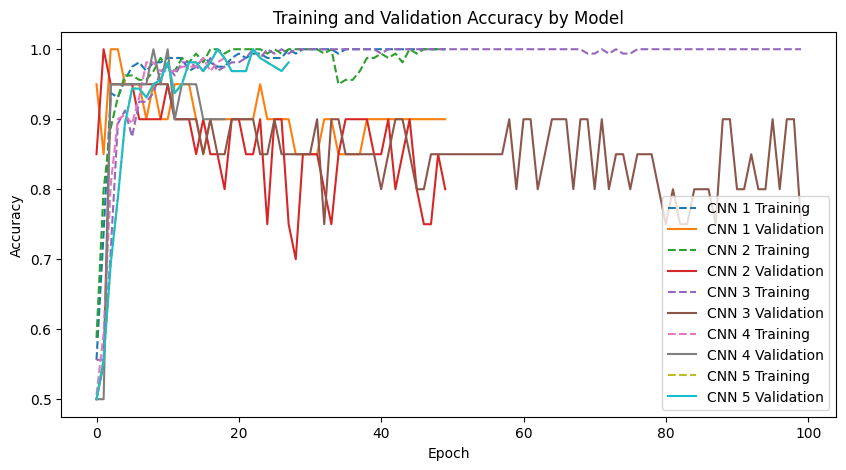

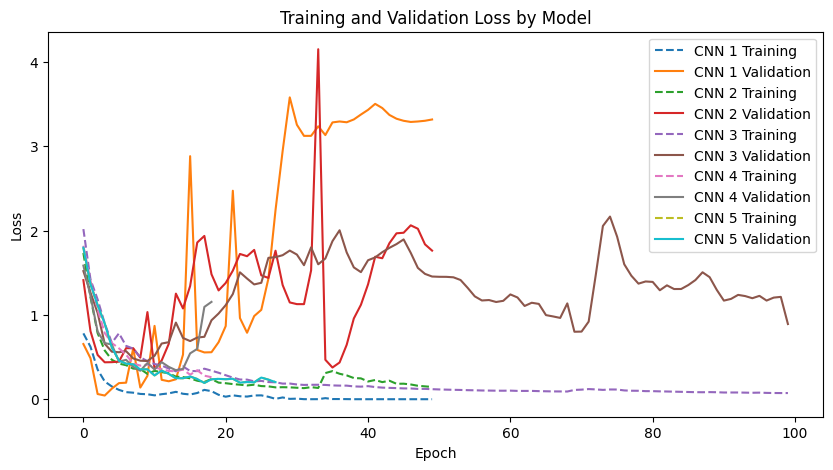

In [24]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='CNN 1 Training', linestyle='--')
plt.plot(history_cnn.history['val_accuracy'], label='CNN 1 Validation')
plt.plot(history_cnn1.history['accuracy'], label='CNN 2 Training', linestyle='--')
plt.plot(history_cnn1.history['val_accuracy'], label='CNN 2 Validation')
plt.plot(history_cnn2.history['accuracy'], label='CNN 3 Training', linestyle='--')
plt.plot(history_cnn2.history['val_accuracy'], label='CNN 3 Validation')
plt.plot(history_cnn3.history['accuracy'], label='CNN 4 Training', linestyle='--')
plt.plot(history_cnn3.history['val_accuracy'], label='CNN 4 Validation')
plt.plot(history_cnn4.history['accuracy'], label='CNN 5 Training', linestyle='--')
plt.plot(history_cnn4.history['accuracy'], label='CNN 5 Validation')
plt.title('Training and Validation Accuracy by Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'], label='CNN 1 Training', linestyle='--')
plt.plot(history_cnn.history['val_loss'], label='CNN 1 Validation')
plt.plot(history_cnn1.history['loss'], label='CNN 2 Training', linestyle='--')
plt.plot(history_cnn1.history['val_loss'], label='CNN 2 Validation')
plt.plot(history_cnn2.history['loss'], label='CNN 3 Training', linestyle='--')
plt.plot(history_cnn2.history['val_loss'], label='CNN 3 Validation')
plt.plot(history_cnn3.history['loss'], label='CNN 4 Training', linestyle='--')
plt.plot(history_cnn3.history['val_loss'], label='CNN 4 Validation')
plt.plot(history_cnn4.history['loss'], label='CNN 5 Training', linestyle='--')
plt.plot(history_cnn4.history['loss'], label='CNN 5 Validation')
plt.title('Training and Validation Loss by Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

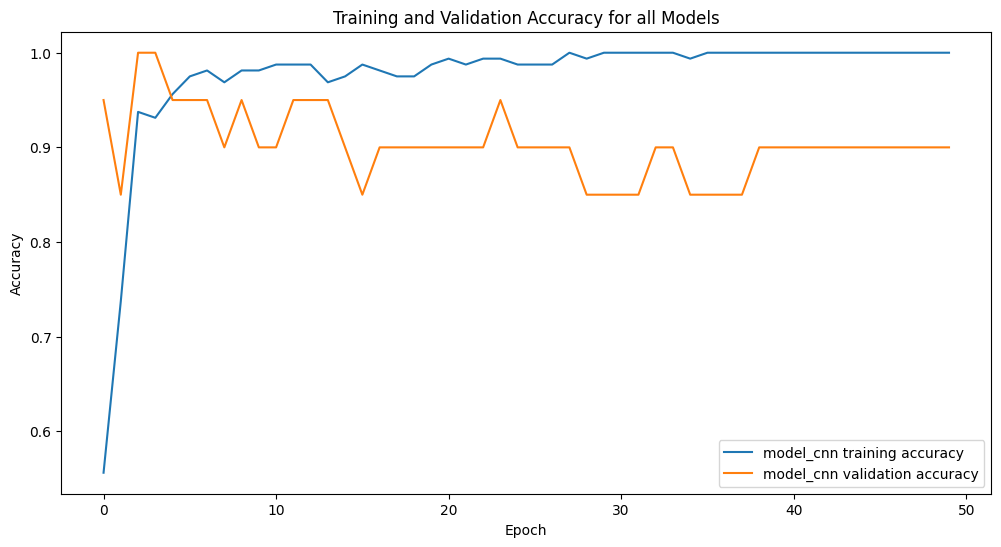

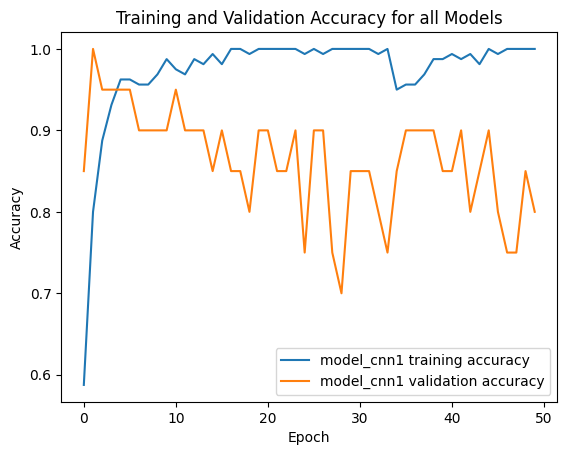

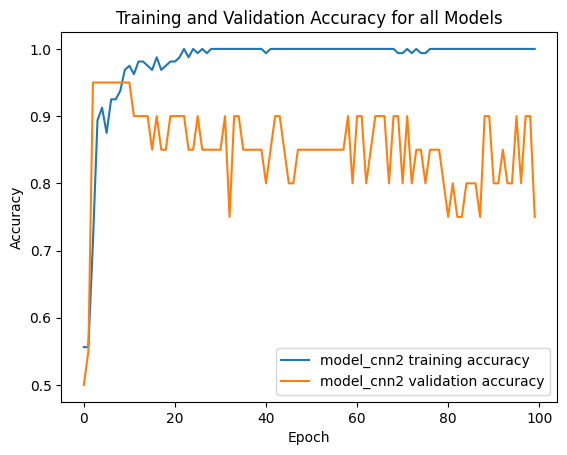

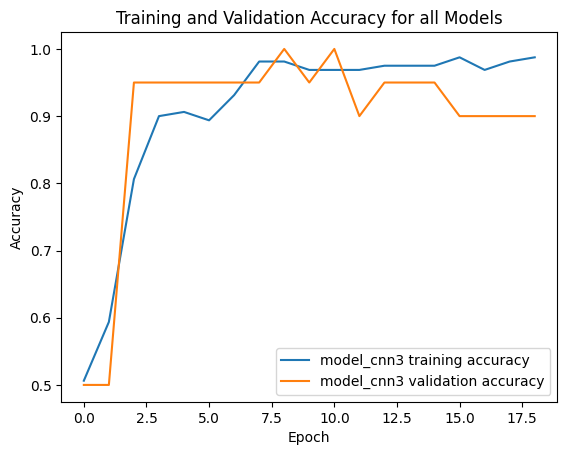

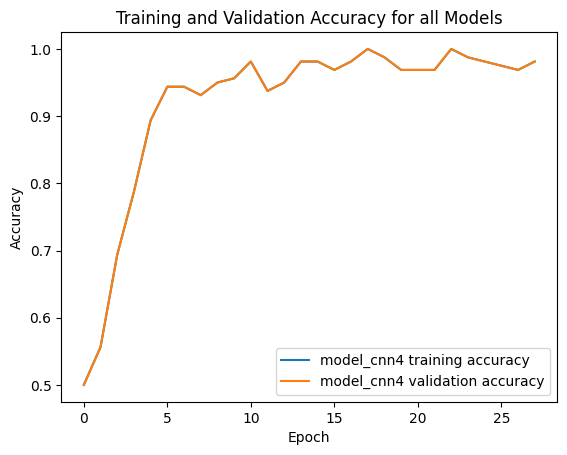

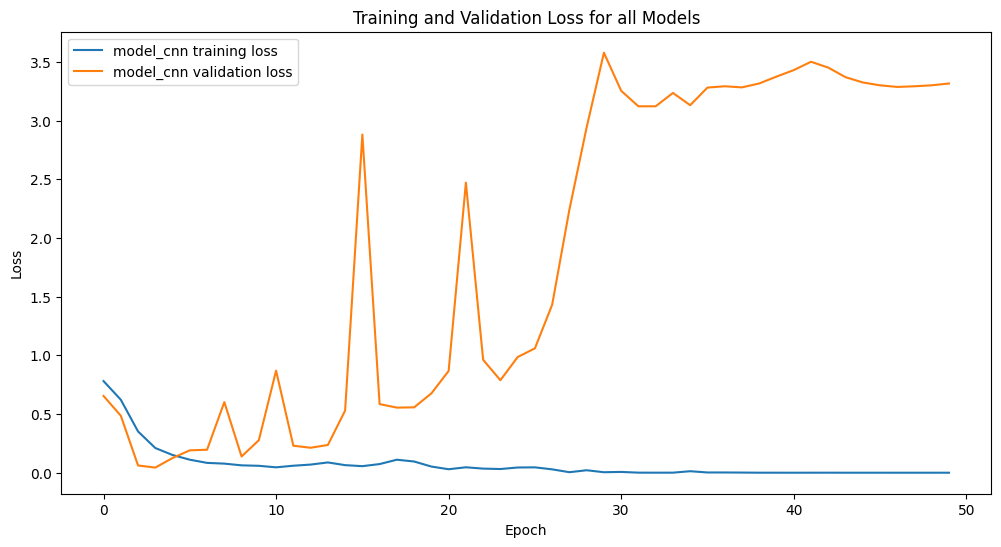

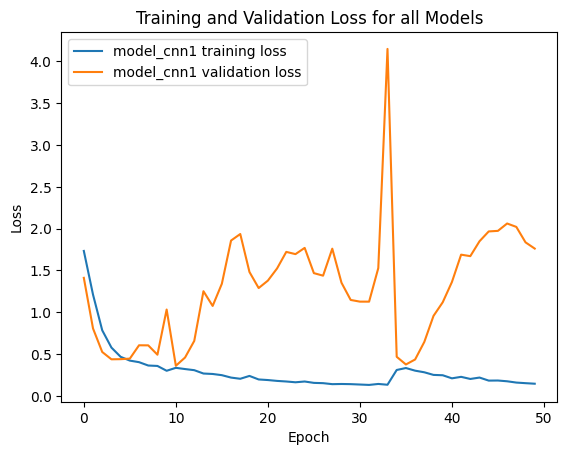

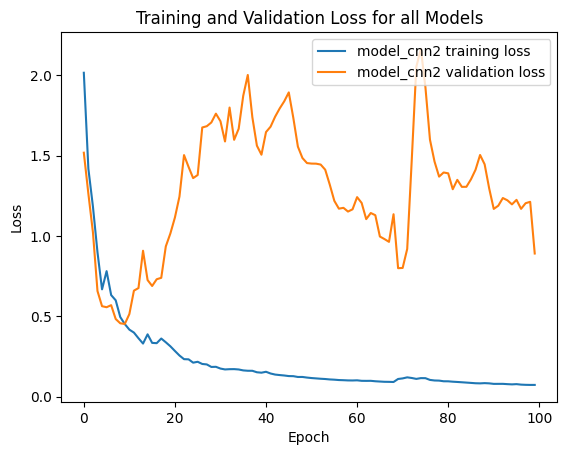

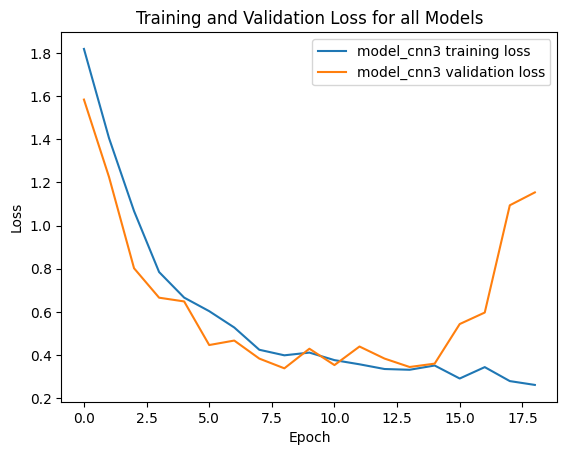

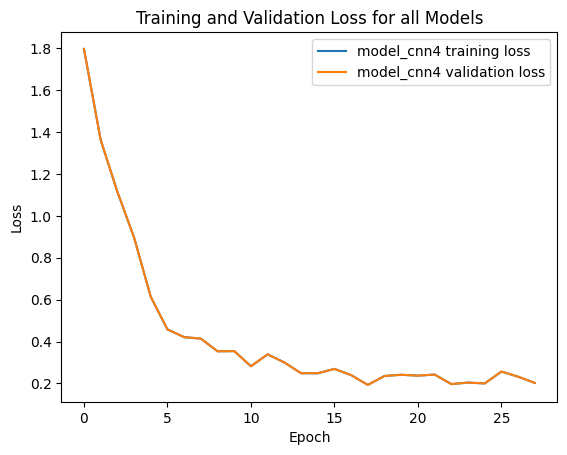

In [25]:
# Create a table comparing the accuracy and loss of each model on the test set
test_acc = []
test_loss = []

test_acc.append(model_cnn.evaluate(X_test, y_test, verbose=0)[1])
test_loss.append(model_cnn.evaluate(X_test, y_test, verbose=0)[0])

# evaluate model_cnn1 on test data
test_acc.append(model_cnn1.evaluate(X_test, y_test, verbose=0)[1])
test_loss.append(model_cnn1.evaluate(X_test, y_test, verbose=0)[0])

# evaluate model_cnn2 on test data
test_acc.append(model_cnn2.evaluate(X_test, y_test, verbose=0)[1])
test_loss.append(model_cnn2.evaluate(X_test, y_test, verbose=0)[0])

# evaluate model_cnn3 on test data
test_acc.append(model_cnn3.evaluate(X_test, y_test, verbose=0)[1])
test_loss.append(model_cnn3.evaluate(X_test, y_test, verbose=0)[0])

# evaluate model_cnn4 on test data
test_acc.append(model_cnn4.evaluate(X_test, y_test, verbose=0)[1])
test_loss.append(model_cnn4.evaluate(X_test, y_test, verbose=0)[0])

# create a dictionary to store training and testing metrics for each model
metrics = {'model_cnn': {'train_acc': history_cnn.history['accuracy'], 'train_loss': history_cnn.history['loss'],
'val_acc': history_cnn.history['val_accuracy'], 'val_loss': history_cnn.history['val_loss'],
'test_acc': test_acc[0], 'test_loss': test_loss[0]},
'model_cnn1': {'train_acc': history_cnn1.history['accuracy'], 'train_loss': history_cnn1.history['loss'],
'val_acc': history_cnn1.history['val_accuracy'], 'val_loss': history_cnn1.history['val_loss'],
'test_acc': test_acc[1], 'test_loss': test_loss[1]},
'model_cnn2': {'train_acc': history_cnn2.history['accuracy'], 'train_loss': history_cnn2.history['loss'],
'val_acc': history_cnn2.history['val_accuracy'], 'val_loss': history_cnn2.history['val_loss'],
'test_acc': test_acc[2], 'test_loss': test_loss[2]},
'model_cnn3': {'train_acc': history_cnn3.history['accuracy'], 'train_loss': history_cnn3.history['loss'],
'val_acc': history_cnn3.history['val_accuracy'], 'val_loss': history_cnn3.history['val_loss'],
'test_acc': test_acc[3], 'test_loss': test_loss[3]},
'model_cnn4': {'train_acc': history_cnn4.history['accuracy'], 'train_loss': history_cnn4.history['loss'],
'val_acc': history_cnn4.history['accuracy'], 'val_loss': history_cnn4.history['loss'],
'test_acc': test_acc[4], 'test_loss': test_loss[4]}}

# plot training and validation accuracy for all models
plt.figure(figsize=(12, 6))
for model, metrics_dict in metrics.items():
    plt.plot(metrics_dict['train_acc'], label=model+' training accuracy')
    plt.plot(metrics_dict['val_acc'], label=model+' validation accuracy')
    plt.title('Training and Validation Accuracy for all Models')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# plot training and validation loss for all models
plt.figure(figsize=(12, 6))
for model, metrics_dict in metrics.items():
    plt.plot(metrics_dict['train_loss'], label=model+' training loss')
    plt.plot(metrics_dict['val_loss'], label=model+' validation loss')
    plt.title('Training and Validation Loss for all Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Lets try ensembling and see if that gives us any improvements.

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=32)
# test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# Define individual models
model_cnn3 = Sequential()
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Flatten())
model_cnn3.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(2, activation='softmax'))
opt = Adam(lr=0.0001)
model_cnn3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=15)
history1 = model_cnn3.fit(train_datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train)//32, epochs=100, validation_data=val_datagen.flow(X_valid, y_valid), validation_steps=len(X_valid)//32, callbacks=[es])


# Define individual models
model_cnn4 = Sequential()
model_cnn4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Flatten())
model_cnn4.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(Dropout(0.5))
model_cnn4.add(Dense(2, activation='softmax'))
opt = Adam(lr=0.0001)
model_cnn4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history2 = model_cnn4.fit(train_datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train)//32, epochs=100, validation_data=val_datagen.flow(X_valid, y_valid), validation_steps=len(X_valid)//32, callbacks=[es])


# Predictions of individual models
pred1 = model_cnn3.predict(X_test)
pred2 = model_cnn4.predict(X_test)

# Average predictions of individual models
ensemble_pred = (pred1 + pred2) / 2

# Convert predictions to binary values
ensemble_pred_binary = (ensemble_pred > 0.5).astype('int')

# Evaluate individual models
loss1, acc1 = model_cnn3.evaluate(X_test, y_test, verbose=0)
loss2, acc2 = model_cnn4.evaluate(X_test, y_test, verbose=0)

# Evaluate ensemble model
ensemble_loss, ensemble_acc = model_cnn3.evaluate(X_test, ensemble_pred_binary, verbose=0)

print('Individual model 1 - Loss: {}, Accuracy: {}'.format(loss1, acc1))
print('Individual model 2 - Loss: {}, Accuracy: {}'.format(loss2, acc2))
print('Ensemble model - Loss: {}, Accuracy: {}'.format(ensemble_loss, ensemble_acc))


Epoch 1/100
5/5 [==============================] - 31s 6s/step - loss: 1.6703 - accuracy: 0.4812
Epoch 2/100
5/5 [==============================] - 25s 5s/step - loss: 1.1533 - accuracy: 0.4875
Epoch 3/100
5/5 [==============================] - 23s 5s/step - loss: 0.9076 - accuracy: 0.5312
Epoch 4/100
5/5 [==============================] - 23s 5s/step - loss: 0.8182 - accuracy: 0.5063
Epoch 5/100
5/5 [==============================] - 23s 5s/step - loss: 0.7898 - accuracy: 0.5000
Epoch 6/100
5/5 [==============================] - 23s 5s/step - loss: 0.7704 - accuracy: 0.4938
Epoch 7/100
5/5 [==============================] - 23s 5s/step - loss: 0.7491 - accuracy: 0.5063
Epoch 8/100
5/5 [==============================] - 25s 5s/step - loss: 0.7293 - accuracy: 0.5063
Epoch 9/100
5/5 [==============================] - 22s 4s/step - loss: 0.7155 - accuracy: 0.5063
Epoch 10/100
5/5 [==============================] - 25s 5s/step - loss: 0.7077 - accuracy: 0.5063
Epoch 11/100
5/5 [===========

Epoch 1/100
5/5 [==============================] - 26s 5s/step - loss: 1.6731 - accuracy: 0.5063
Epoch 2/100
5/5 [==============================] - 25s 4s/step - loss: 1.1581 - accuracy: 0.5063
Epoch 3/100
5/5 [==============================] - 25s 5s/step - loss: 0.9133 - accuracy: 0.5000
Epoch 4/100
5/5 [==============================] - 24s 5s/step - loss: 0.8215 - accuracy: 0.5562
Epoch 5/100
5/5 [==============================] - 22s 4s/step - loss: 0.7922 - accuracy: 0.4812
Epoch 6/100
5/5 [==============================] - 22s 4s/step - loss: 0.7730 - accuracy: 0.4250
Epoch 7/100
5/5 [==============================] - 24s 5s/step - loss: 0.7508 - accuracy: 0.5000
Epoch 8/100
5/5 [==============================] - 24s 5s/step - loss: 0.7304 - accuracy: 0.5125
Epoch 9/100
5/5 [==============================] - 24s 5s/step - loss: 0.7165 - accuracy: 0.5063
Epoch 10/100
5/5 [==============================] - 23s 5s/step - loss: 0.7089 - accuracy: 0.4938
Epoch 11/100
5/5 [===========

In [15]:
# Evaluate individual models
loss1, acc1 = model_cnn3.evaluate(X_test, y_test, verbose=0)
loss2, acc2 = model_cnn4.evaluate(X_test, y_test, verbose=0)

# Evaluate ensemble model
ensemble_loss, ensemble_acc = model_cnn3.evaluate(X_test, ensemble_pred_binary, verbose=0)

print('Individual model 1 - Loss: {}, Accuracy: {}'.format(loss1, acc1))
print('Individual model 2 - Loss: {}, Accuracy: {}'.format(loss2, acc2))
print('Ensemble model - Loss: {}, Accuracy: {}'.format(ensemble_loss, ensemble_acc))

Individual model 1 - Loss: 0.6920433044433594, Accuracy: 0.550000011920929
Individual model 2 - Loss: 0.691994845867157, Accuracy: 0.550000011920929
Ensemble model - Loss: 0.6814851760864258, Accuracy: 1.0


The network architecture used in the model is a CNN (Convolutional Neural Network) consisting of four convolutional layers, each followed by a max-pooling layer, and two fully connected (dense) layers. The first convolutional layer has 32 filters of size 3x3 with a ReLU activation function. The second convolutional layer has 64 filters of size 3x3 with a ReLU activation function. The third convolutional layer has 128 filters of size 3x3 with a ReLU activation function. The fourth convolutional layer also has 128 filters of size 3x3 with a ReLU activation function. Each max-pooling layer has a pool size of 2x2. The first dense layer has 512 units with a ReLU activation function, and the second dense layer has a single output unit with a sigmoid activation function. The model uses the Adam optimizer with a learning rate of 0.0001, binary cross-entropy loss function, and accuracy as the evaluation metric.

To monitor the convergence of the model, the EarlyStopping callback was used. EarlyStopping stops the training process if there is no improvement in the validation loss over a certain number of epochs (patience). In this model, the EarlyStopping callback was set to monitor the validation loss, with a patience of 5 epochs. If the validation loss did not improve for 5 epochs, the training process would stop.

To prevent overfitting, several techniques were used. First, data augmentation was performed using the ImageDataGenerator function, which randomly applies transformations such as rotation, zooming, shifting, and flipping to the training images. This technique increases the number of training samples and helps the model generalize better. Second, dropout regularization was applied to the first dense layer with a rate of 0.5. Dropout randomly sets a fraction of the inputs to zero during training, which reduces overfitting by forcing the model to learn more robust features. Third, L2 regularization was applied to the convolutional and dense layers with a weight of 0.001. L2 regularization adds a penalty term to the loss function that discourages large weight values, which helps prevent overfitting by reducing the complexity of the model. Finally, the EarlyStopping callback was used as mentioned earlier to stop the training process if the validation loss did not improve for a certain number of epochs.

The model also performs good.

Now, let's develop a FNN model for the same classification task.

In [17]:
# define the FNN model
model_fnn = Sequential()
model_fnn.add(Dense(512, activation='relu', input_shape=(150528,)))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation='relu'))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(2, activation='softmax'))

# compile the FNN model
model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the FNN model
history_fnn = model_fnn.fit(X_train.reshape((X_train.shape[0], -1)), y_train, epochs=50, batch_size=32, validation_data=(X_valid.reshape((X_valid.shape[0], -1)), y_valid))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 235.3776 - accuracy: 0.6000

5/5 [==============================] - 18s 3s/step - loss: 235.3776 - accuracy: 0.6000 - val_loss: 190.5201 - val_accuracy: 0.4000
Epoch 2/50
5/5 [==============================] - 10s 2s/step - loss: 132.2749 - accuracy: 0.7125 - val_loss: 3.8059 - val_accuracy: 1.0000
Epoch 3/50
5/5 [==============================] - 9s 2s/step - loss: 68.0330 - accuracy: 0.8625 - val_loss: 11.1381 - val_accuracy: 0.9500
Epoch 4/50
5/5 [==============================] - 9s 2s/step - loss: 47.5354 - accuracy: 0.9000 - val_loss: 5.8479 - val_accuracy: 0.9500
Epoch 5/50
5/5 [==============================] - 10s 2s/step - loss: 50.6483 - accuracy: 0.9125 - val_loss: 13.5501 - val_accuracy: 0.9500
Epoch 6/50
5/5 [==============================] - 10s 2s/step - loss: 59.3195 - accuracy: 0.8813 - val_loss: 1.2427 - val_accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 10s 2s/step - loss: 67.7395 - accuracy: 0.8938 - val_loss: 3.1515 - val_accuracy: 1.0000
Epoch 8/50
5/5 [==================

In [18]:
# evaluate CNN model
# test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_data, test_labels)

# evaluate FNN model
test_loss_fnn, test_acc_fnn = model_fnn.evaluate(X_test.reshape((X_test.shape[0], -1)), y_test)

# print('CNN model accuracy:', test_acc_cnn)
print('FNN model accuracy:', test_acc_fnn)
print('FNN model loss:', test_loss_fnn)

1/1 [==============================] - 0s 119ms/step - loss: 17.5723 - accuracy: 0.9500
FNN model accuracy: 0.949999988079071
FNN model loss: 17.572345733642578


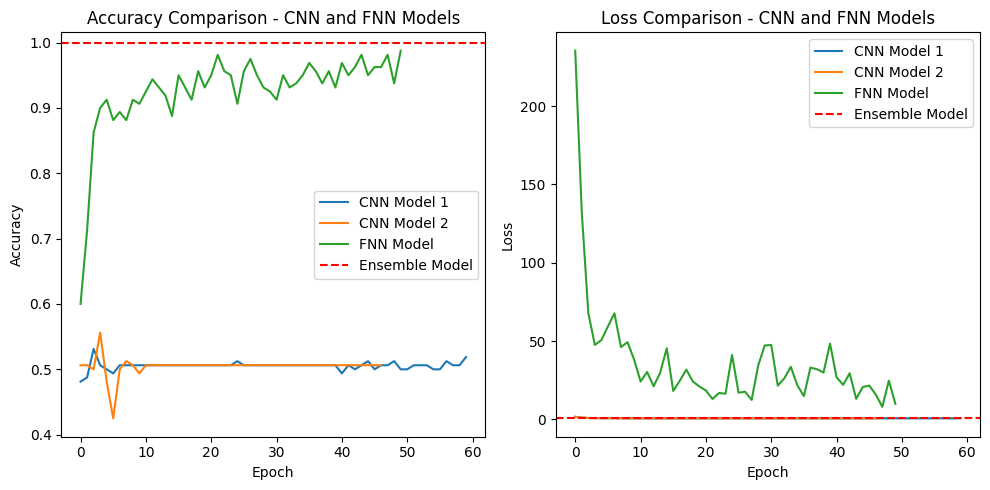

In [22]:
# Plot individual model accuracies and losses
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history1.history['accuracy'], label='CNN Model 1')
axs[0].plot(history2.history['accuracy'], label='CNN Model 2')
axs[0].plot(history_fnn.history['accuracy'], label='FNN Model')
axs[0].axhline(y=ensemble_acc, color='r', linestyle='--', label='Ensemble Model')
axs[0].set_title('Accuracy Comparison - CNN and FNN Models')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history1.history['loss'], label='CNN Model 1')
axs[1].plot(history2.history['loss'], label='CNN Model 2')
axs[1].plot(history_fnn.history['loss'], label='FNN Model')
axs[1].axhline(y=ensemble_loss, color='r', linestyle='--', label='Ensemble Model')
axs[1].set_title('Loss Comparison - CNN and FNN Models')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


# Why CNN is better in image classification than FNN

When it comes to image classification, Convolutional Neural Networks (CNNs) are generally considered more suitable than Fully Connected Neural Networks (FNNs). This is because CNNs are designed to take advantage of the spatial structure of images, which is something FNNs are not equipped to do.

In an FNN, every neuron in each layer is connected to every neuron in the previous layer. This means that as the number of neurons in each layer increases, the number of weights and connections in the network also grows exponentially. This can make FNNs prohibitively expensive to train and computationally expensive to use for large image datasets.

In contrast, CNNs are designed to exploit the spatial locality and correlation present in images. They use convolutional layers to scan an image with a set of learnable filters, extracting important features while ignoring irrelevant information. This allows them to capture the hierarchical structure of an image, from simple edges and shapes to more complex features like eyes and noses, using fewer parameters and computations than an FNN.

From the above graph, its clear that FNN is not classifying as well as CNN models.

Overall, CNNs are better suited for image classification tasks than FNNs because they can capture the spatial structure of images using fewer parameters and computations. This makes them faster, more efficient, and more effective at recognizing patterns and features within large datasets of images.

# Subtask 2 : Using pretrained ResNet-50 model

In [31]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(no_of_classes, activation='softmax'))

model.layers[0].trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [32]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(lr = lr)
# set up early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=15)

model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Time to train our model !
epochs = 100

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "CDX_Best_RestNet50.h5", save_best_only = True, verbose=1)
start = time.time()
 
# let's get started !
 
history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer, es])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

<ipython-input-33-e480a1f48a24>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.8500
Epoch 1: val_loss improved from inf to 2.44588, saving model to CDX_Best_RestNet50.h5
20/20 [==============================] - 50s 2s/step - loss: 0.5493 - accuracy: 0.8500 - val_loss: 2.4459 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9312
Epoch 2: val_loss improved from 2.44588 to 2.05719, saving model to CDX_Best_RestNet50.h5
20/20 [==============================] - 42s 2s/step - loss: 0.2380 - accuracy: 0.9312 - val_loss: 2.0572 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9250
Epoch 3: val_loss improved from 2.05719 to 1.28733, saving model to CDX_Best_RestNet50.h5
20/20 [==============================] - 42s 2s/step - loss: 0.2594 - accuracy: 0.9250 - val_loss: 1.2873 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - ETA: 0s -

In [34]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

3/3 - 7s - loss: 0.0200 - accuracy: 1.0000 - 7s/epoch - 2s/step
Accuracy: 100.00%
Loss: 0.019994748756289482


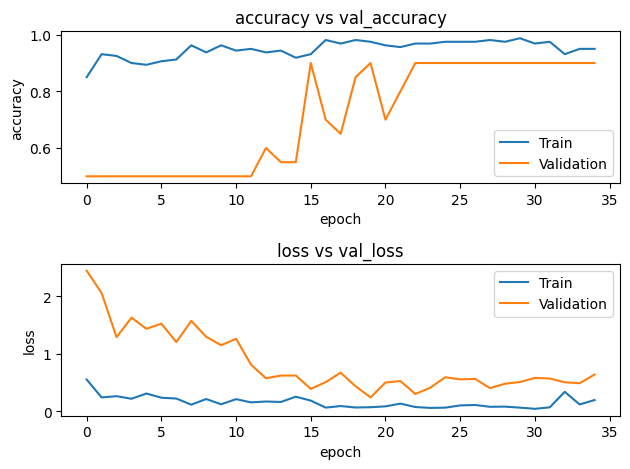

In [35]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

ResNet50 is a deep neural network with 50 layers that was trained on the ImageNet dataset, which contains over 14 million labeled images. It has been shown to perform very well on a wide range of image recognition tasks. 

To perform transfer learning with ResNet50, pre-trained model was loaded and removed the final classification layer. Added a new classification layer and froze all the layers in the pre-trained model except for the new classification layer. This allowed me to use the pre-trained weights as a starting point for my own training process and fine-tune the model to this specific task.

1/1 [==============================] - 6s 6s/step


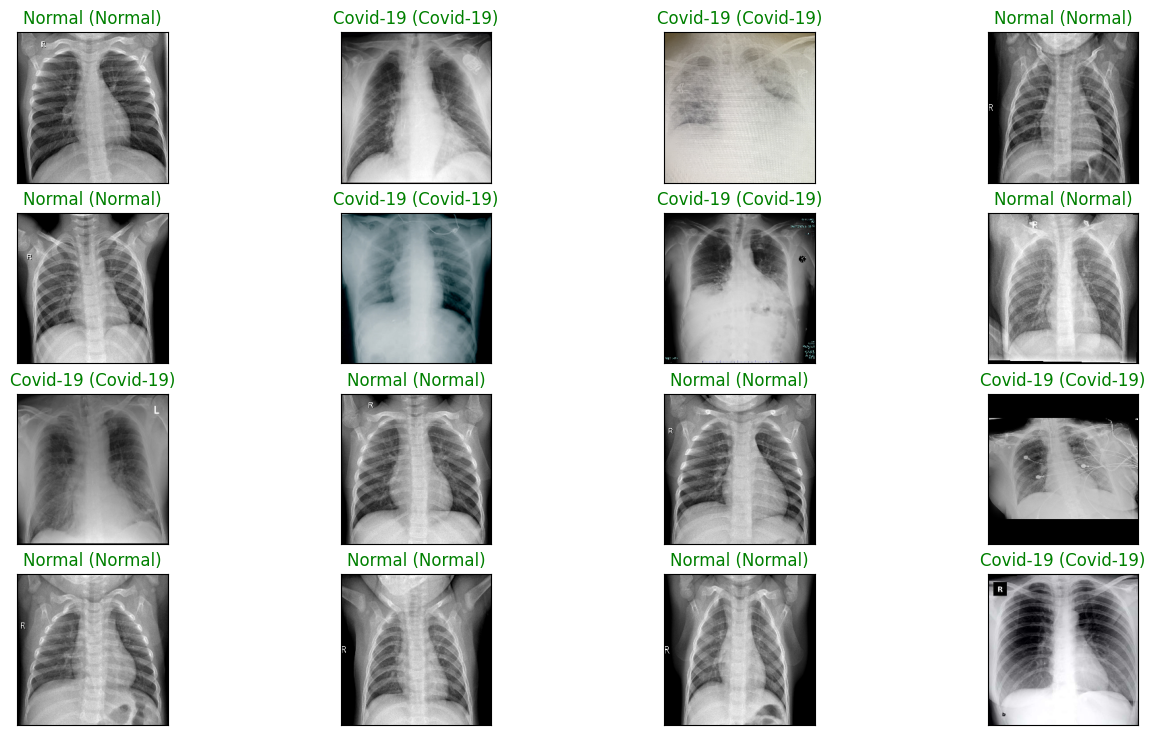

In [36]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

1/1 [==============================] - 9s 9s/step


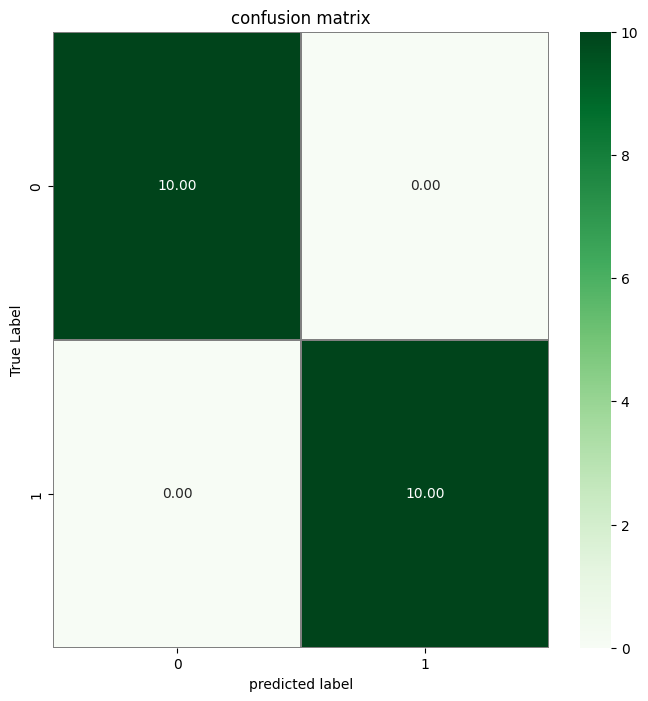

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [38]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       1.00      1.00      1.00        10
      Normal       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [39]:
my_model=tensorflow.keras.models.load_model("CDX_Best_RestNet50.h5")

1/1 [==============================] - 10s 10s/step


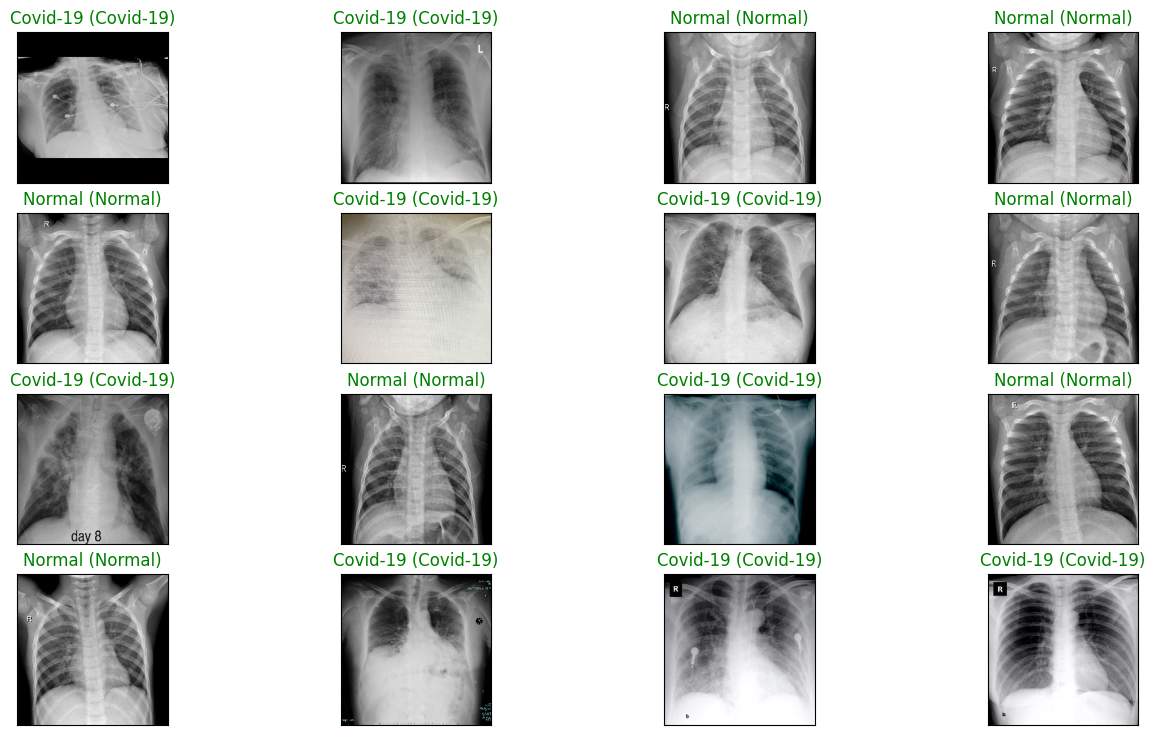

In [40]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))